# Hands-On Image Processing with OpenCV (Day 2, Second Session)

Welcome to Day 2 (Session 2). Now we will put theory into practice using OpenCV, a powerful computer vision library. By the end of this session, you will have a working routine that:
- Loads an image from the camera (or provided sample image).
- Converts it to HSV color space.
- Creates a mask to isolate a specific color.
- Finds contours of the objects of that color.
- Draws boundaries and centers of those objects on the image.
- Allows you to adjust parameters like color range and contour size threshold to see their effects.

Let's get started!

## 1. Setup and Sample Image

First, we need to set up our environment. In Google Colab, OpenCV (cv2) is usually pre-installed, but if you're running elsewhere, you might need to install it. We will also use matplotlib for displaying images in the notebook.

Important: Make sure you have the sample image file sample_objects.jpg ready (it should contain a few distinct colored objects on a simple background – for example, colored blocks or balls on a white table). If you're in Colab, you can upload the file by clicking the folder icon on the left and dragging the image in, or use `files.upload()`. This time we will use `wget` to download a image from online.


In [2]:
# If OpenCV or other libraries are not installed in your environment, uncomment and run the below:
# !pip install opencv-python matplotlib


In [3]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots appear inline in the notebook
%matplotlib inline


Now let's load the image. We use `cv2.imread` for this. By default, imread will load the image in BGR color format. Replace '`sample_objects.jpg`' with the path to your image if it's named differently or in a different location.


In [7]:


# Load the image using OpenCV
image_path = 'strawberry.png'  # ensure this file is uploaded in your notebook environment
img = cv2.imread(image_path)

# Check if image loaded correctly
if img is None:
    print("Error: Could not load image. Make sure 'sample_objects.jpg' is uploaded.")
else:
    print("Image loaded successfully! Shape:", img.shape)


Image loaded successfully! Shape: (168, 194, 3)


If the image is loaded successfully, img.shape will print (height, width, 3) for the dimensions. If you see an error, make sure the file name is correct and the file is uploaded.

Let's visualize the original image to see what it looks like. We will use matplotlib for that. However, recall that OpenCV uses BGR ordering, while matplotlib expects RGB. We should convert the color order before displaying to get correct colors.

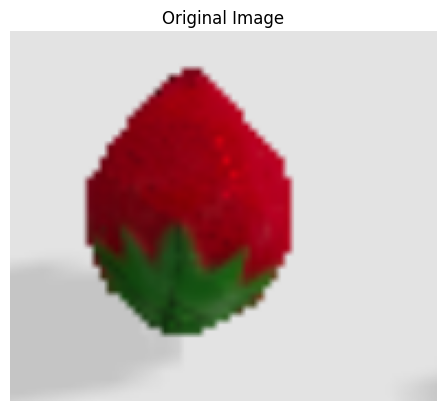

In [8]:
# Display the original image using matplotlib
if img is not None:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')  # hide axis ticks
    plt.show()


You should see the original image displayed above. Now we have our input ready.

## 2. Color Conversion (BGR to HSV)

As discussed, we will convert the image to the HSV color space to make color detection easier. OpenCV provides cv2.cvtColor for color conversions.

In [9]:
# Convert the BGR image to HSV color space
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
print("Converted to HSV. Image shape (should be same as original):", hsv_img.shape)


Converted to HSV. Image shape (should be same as original): (168, 194, 3)


The shape should match the original image (still height x width x 3, just different meaning for the 3 channels now). We can do a quick check on what HSV values look like, but it's a bit meaningless to print a lot of them. Instead, we'll go straight into using HSV for masking.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/33/HSV_color_solid_cylinder_saturation_gray.png
" alt="HSV Image" width="400"/>

Choosing a color range: We need to decide which color to detect. For instance, if our image has a distinct green object, let's target that first. We have to define a lower and upper bound for the HSV values that correspond to green.

How to choose the range? We can use known HSV values:
- Pure green in HSV is around Hue = 60° (which is 30 in OpenCV scale since OpenCV uses 0-179). But objects that are "green" might have hues a bit above or below, and some saturation/value variation.
- We might start with a range like Hue 50-70 (on OpenCV scale), Saturation 100-255, Value 100-255. This assumes the object is fairly saturated and bright. If it’s darker or lighter, we adjust value range accordingly.


Let's define a HSV range for the color of interest. (Feel free to adjust these numbers if your image’s object isn't detected well.)

In [22]:
# Define HSV range for the target color (example: green color range)
lower_color = np.array([0, 100, 90])   # lower bound (H, S, V)
upper_color = np.array([255, 255, 255]) # upper bound (H, S, V)



# Create a binary mask where color within range -> white (255), outside range -> black (0)
mask = cv2.inRange(hsv_img, lower_color, upper_color)
print("Mask created. Mask shape:", mask.shape, "| Data type:", mask.dtype)
print("Unique values in mask:", np.unique(mask))


Mask created. Mask shape: (168, 194) | Data type: uint8
Unique values in mask: [  0 255]


The mask is a 2D array (single channel) with the same width/height as the image. We expect the unique values to be [0, 255] if the mask is properly binary. If you see only [0], it means our range didn't catch anything (we might need to broaden the range or choose a different color).

Let's visualize the mask to see where our chosen color is being detected:

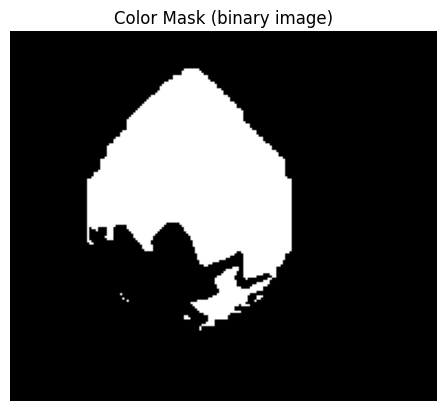

In [23]:
# Display the mask image
plt.imshow(mask, cmap='gray')
plt.title("Color Mask (binary image)")
plt.axis('off')
plt.show()


You should see a black image with white regions where the target color was present. Ideally, each white blob corresponds to an object of that color in the original image. If your mask is all black or missing the object, we may need to adjust the lower_color and upper_color values.

For example:
- If you expected something to be white but it's not, maybe the hue range is off – try widening it (e.g., 40 to 80).
- If the object is present but partially black, maybe the saturation or value thresholds cut it off. For a very bright object, you might need to allow higher value range; for a pale object, allow lower saturation, etc.
- If you get extra white spots (false positives), you might narrow the ranges.

This experimentation is normal in CV – finding the right threshold often requires tuning.

## 3. Finding Contours

Now that we have a mask highlighting the regions of the target color, we want to identify the contours of those regions. A contour is basically the outline of a shape (a continuous curve bounding a white region in the binary mask).

OpenCV has cv2.findContours for this. We will use cv2.findContours(mask, mode, method). The mode can be cv2.RETR_EXTERNAL to retrieve only outer contours (which is what we want, assuming objects are separate and not nested). The method can be cv2.CHAIN_APPROX_SIMPLE to compress contour points (not store all boundary points, which is fine for our needs).

Let's find the contours:

In [24]:
# Find contours in the mask
# cv2.findContours returns a tuple: (list_of_contours, hierarchy)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Found {len(contours)} contours in the mask.")
# Optional: print the area of each contour
for idx, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    print(f"Contour {idx} has area {area}")


Found 6 contours in the mask.
Contour 0 has area 1.5
Contour 1 has area 0.0
Contour 2 has area 0.0
Contour 3 has area 1.5
Contour 4 has area 0.0
Contour 5 has area 5769.5


We printed the area of each found contour. This helps us gauge sizes of detected objects. Sometimes, small contours might be just noise (for example, a tiny white speck in the mask). We can filter those out by area.

Let's decide on a minimum area threshold to consider a contour as an actual object. This will depend on your image resolution and object size. If you're not sure, look at the areas printed above and pick a cutoff somewhat smaller than the smallest legitimate object. For example, if a real object has area ~1500, and you see some contours of area 20 or 5 (likely noise), you might choose something like 500 as a threshold.

In [25]:
# Define a minimum contour area to filter noise
min_area = 500  # you can adjust this value based on printed areas

# Filter contours by area
filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
print(f"{len(filtered_contours)} contours remain after filtering by area >= {min_area}.")


1 contours remain after filtering by area >= 500.


Now, we have a list filtered_contours that should ideally contain only the meaningful objects. We will use this list for drawing and further processing.

## 4. Drawing Contours and Object Centers

Let's draw the contours on the original image to see the detection results. We also want to mark the center of each detected object. The center can be obtained by calculating the moments of the contour (using cv2.moments) and then cx = M['m10']/M['m00'], cy = M['m01']/M['m00'], which gives the centroid coordinates. We will:
- Draw each contour outline in a certain color (say, red).
- Draw a small filled circle at the centroid (say, blue).
- Maybe later, we could also draw the contour's area or ID next to it using text (optional).

We'll create a copy of the original image to draw on, so we don't alter the original data.



In [26]:
# Make a copy of the original image to draw on
output_img = img.copy()

# Loop over each filtered contour and draw it and its center
for c in filtered_contours:
    # Draw the contour outline on output_img in red color, thickness 2
    cv2.drawContours(output_img, [c], -1, (0, 0, 255), 2)  # BGR (0,0,255) is red

    # Compute the center of the contour
    M = cv2.moments(c)
    if M['m00'] != 0:  # to avoid division by zero
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        # Draw a blue filled circle at the center
        cv2.circle(output_img, (cx, cy), 5, (255, 0, 0), -1)  # BGR (255,0,0) is blue
        print(f"Object at ({cx}, {cy})")
    else:
        print("Contour with zero area, skipping center calculation.")


Object at (84, 69)


The print statements will list the center coordinates of each detected object (in pixel terms). These coordinates are relative to the image (with (0,0) at the top-left corner). In a real robot, one would convert these to real-world coordinates if needed, but that's beyond our scope here. We just want to see that we can pinpoint them.

Now, let's display the output image with contours and centers drawn:


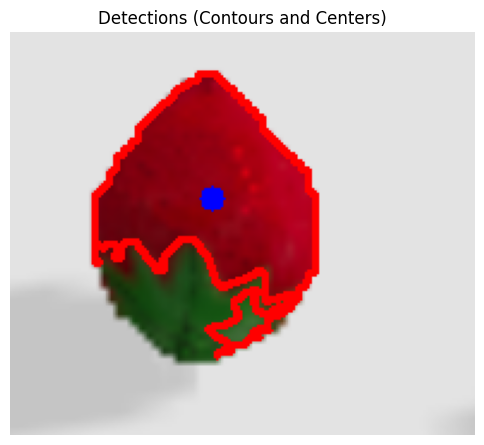

In [27]:
# Show the output image with contours and centers
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Detections (Contours and Centers)")
plt.axis('off')
plt.show()


You should see the original image with red outlines around the detected objects of the target color and blue dots marking their centers. If everything went well, the objects of the color range we set are highlighted. Take a moment to observe:
- Did it detect all instances of that color?
- Are there any false detections (contours around areas that are not actually the target objects)?
- Are the centers roughly in the middle of each object?

If the detection isn't perfect, this is normal – we might need to tweak parameters:
- Adjust the HSV threshold range if some objects were missed or if background got picked up.
- Adjust min_area if some real objects were filtered out or too much noise remains.

Feel free to go back to the cell where we set lower_color/upper_color and try different values, then rerun the subsequent steps to see the difference.

## Interpreting Results and Next Steps
At this point, our code has effectively located objects by color. In a full robotics project, the next steps might be:
- Use the pixel coordinates of the object to align the robot or move a robotic arm to that position.
- If using a calibrated system, convert pixel positions to real-world coordinates (this involves camera calibration and maybe depth sensing, which is beyond today).
- Repeat for other colors or continuously to allow the robot to sort multiple categories.

For our workshop, the main goal was to introduce you to how a robot can "see" color. The combination of HSV thresholding and contour detection is a simple yet powerful technique for tasks like sorting by color. Let's summarize what each part of our pipeline did:
1. Color Conversion: BGR -> HSV to make color-based thresholding easier (since HSV separates color from brightness).
2. Color Masking: cv2.inRange creates a mask of only the desired color range. This is our thresholding step, turning the image into a binary mask.
3. Contour Finding: cv2.findContours finds continuous regions of white in that mask, giving us object candidates.
4. Filtering Contours: We removed tiny contours by area to ignore noise.
5. Drawing Results: We drew contours and computed centers (using moments) to visualize detections.

Each of these steps is common in computer vision applications for robotics. For instance, in a line-following robot, one might threshold the image for a certain line color and find its contour or shape. In our sorting robot, we threshold for object colors.

## Play and Reflect
Now that the pipeline is set up, you are encouraged to try a few things:
- Try a different color: If your image has multiple colored objects, modify the lower_color and upper_color to target another color and rerun the cells. See how the mask and detections change. (Remember to reset min_area if needed for differently sized objects.)
- Change HSV ranges: Make the hue range very narrow vs wide to see the effect. Or try allowing lower saturation (if you set it to 0, you'll also catch grayish shades).
- Adjust contour area threshold: Lower it to catch smaller bits (you might start seeing noise), or raise it to only catch big objects (small objects disappear).

What do you observe when you make these changes? This experimentation will deepen your understanding of the role of each parameter:
- Hue range picks the color.
- Sat/Val range deal with how faded/bright the color must be.
- Min area filters size.

Try to get a feeling for how sensitive the detection is to lighting. For example, if you artificially darken the image (not covered here), the same object might fall out of the value range. In real scenarios, consistent lighting or adaptive methods might be needed.

Exercise (Optional): If you have time, try to modify the code to detect two different colors and draw each in a different outline color. One way is to create two masks (e.g., one for red, one for blue) and combine them (logical OR) or process separately. This is a bit more advanced, but a fun challenge if you've mastered the above steps.

## 5. Conclusion

Congrats! You've implemented a basic computer vision system for color-based object detection:
- We saw how to go from a raw image to useful information (object locations).
- We reinforced Python skills by writing and modifying the code.
- We used OpenCV functions that are widely used in industry and research.

This forms the foundation for our sorting robot's vision. Going forward, we could integrate this with robot motion: for example, once we know there's a blue object at (x,y) in the image, we could command the robot arm to move to that location and pick it up. That would involve coordinate transformations and robot kinematics, which are beyond today's scope but exactly where vision meets robotics.

Before we wrap up, consider:

- What limitations does this approach have? (e.g., what if objects are very similar in color to the background, or to each other? what about lighting changes?)
- How could we improve it? (e.g., use more advanced techniques like machine learning to classify objects by color, or use multiple thresholds to separate hues better, or add morphological operations to clean noise.)

Even with these limitations, color thresholding is a handy tool. Many real-world robotic systems start with simple vision techniques like these for tasks that don't require full AI object recognition. For example, industrial robots often use color or shape cues to sort parts on an assembly line.

Great job today exploring computer vision! You not only refreshed Python but also applied it to make a computer "see." Keep these concepts in mind as we continue building our sorting robot. In the next sessions, we'll integrate this with the robotics side.